<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson4_ReID_YOLO_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📚 Урок 4 — Теория: ReID, ResNet и Трекинг


🔎 Что такое ReID (Re-Identification)?

ReID — это задача повторной идентификации объектов (обычно людей) на разных изображениях или кадрах.
Цель: понять, является ли объект на кадре X тем же, что и на кадре Y, несмотря на смену ракурса, освещения, позы.

🧠 Как это работает?
Сначала детектор (например, YOLOv8) находит объекты (bounding boxes).

Затем из каждого объекта вырезается изображение (patch).

Этот patch пропускается через ReID модель (например, ResNet), чтобы получить вектор признаков — embedding.

Embedding сравниваются между кадрами — если вектора близки, то это один и тот же объект.

🏗️ ResNet: что это и зачем?

ResNet (Residual Network) — семейство сверточных нейросетей с остаточными связями (skip connections), которые позволяют строить очень глубокие модели (до 152 слоев) без проблем исчезающего градиента.

📌 Идея:

Output
=
Input
+
𝐹
(
Input
)
Output=Input+F(Input)

📊 Варианты ResNet:

Модель	Глубина	Где применяют
ResNet18	18	Легкие задачи
ResNet50	50	Стандарт в ReID и CV
ResNet101+	101+	Когда важна точность

✅ Почему ResNet для ReID?

Хорошо извлекает визуальные признаки: текстура, цвет, форма.

Обобщается на новых людей (не только из train-датасета).

Прост в использовании и есть в torchreid, DeepSORT, и др.

🔄 Альтернативы:

Модель	Преимущества
OSNet	Компактный, заточен под ReID
EfficientNet	Легкий, мощный
TransReID	На базе Vision Transformers

📌 Вывод:

ResNet — отличный выбор для извлечения эмбеддингов.
Но если ты хочешь ускорить обработку или перейти на state-of-the-art, стоит попробовать OSNet или TransReID.



In [16]:
!pip install ultralytics torch torchvision torchaudio
!pip install git+https://github.com/KaiyangZhou/deep-person-reid.git
!pip install scikit-learn matplotlib pandas opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00
  Cloning https://github.com/KaiyangZhou/deep-person-reid.git to /tmp/pip-req-build-k39hpzoi
  Running command git clone --filter=blob:none --quiet https://github.com/KaiyangZhou/deep-person-reid.git /tmp/pip-req-build-k39hpzoi
  Resolved https://github.com/KaiyangZhou/deep-person-reid.git to commit 566a56a2cb255f59ba75aa817032621784df546a
  Preparing metadata (setup.py) ... done


In [17]:
from google.colab import files
uploaded = files.upload()


Saving video_1.mp4 to video_1.mp4


In [22]:
# Инициализация YOLO и ReID модели

from ultralytics import YOLO
import torchreid
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import cv2

# YOLOv8
detector = YOLO('yolov8n.pt')

# ReID модель
reid_model = torchreid.models.build_model('osnet_x0_25', num_classes=1000, pretrained=True)
reid_model.eval()
reid_model.to('cpu')

# Преобразование для ReID
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def get_embedding(patch):
    img = Image.fromarray(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
    img = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = reid_model(img).squeeze()
        return (feat / feat.norm()).numpy()


Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x0_25_imagenet.pth"


In [23]:
video_path = list(uploaded.keys())[0]
cap = cv2.VideoCapture(video_path)

# Видео параметры
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

embeddings_list = []

frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = detector(frame)
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            class_id = int(box.cls[0])

            if class_id != 0:  # только люди
                continue

            obj_patch = frame[y1:y2, x1:x2]
            if obj_patch.size == 0:
                continue

            emb = get_embedding(obj_patch)

            embeddings_list.append({
                'frame_id': frame_id,
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                **{f'emb_{i}': val for i, val in enumerate(emb)}
            })

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)

    out.write(frame)
    frame_id += 1

cap.release()
out.release()



0: 640x352 1 person, 1 potted plant, 163.0ms
Speed: 3.4ms preprocess, 163.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 potted plant, 171.0ms
Speed: 2.6ms preprocess, 171.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 potted plant, 148.1ms
Speed: 3.8ms preprocess, 148.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 potted plant, 154.2ms
Speed: 4.2ms preprocess, 154.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 potted plant, 151.1ms
Speed: 5.5ms preprocess, 151.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 potted plant, 155.0ms
Speed: 5.4ms preprocess, 155.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 person, 1 potted plant, 173.1ms
Speed: 4.5ms preprocess, 173.1ms inference, 2.0ms postprocess per image at shape (1, 3, 64

## Сохраняем эмбеддинги в .csv

In [24]:
df = pd.DataFrame(embeddings_list)
df.to_csv('embeddings.csv', index=False)


## t-SNE визуализация

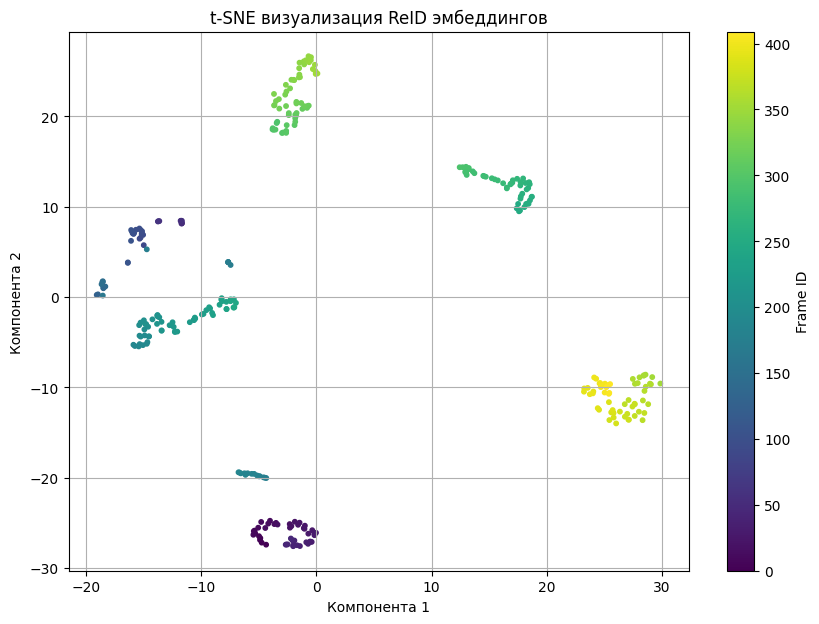

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = df[[col for col in df.columns if col.startswith('emb_')]].values
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['frame_id'], cmap='viridis', s=10)
plt.colorbar(label='Frame ID')
plt.title('t-SNE визуализация ReID эмбеддингов')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.grid(True)
plt.show()


## Скачать обработанное видео и эмбеддинги

In [26]:
from google.colab import files
files.download('output.mp4')
files.download('embeddings.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📐 Урок 4: Задание по линейной алгебре
Тема: Работа с эмбеддингами в виде векторов в пространстве

🧠 Цель:
Понять, как эмбеддинги ведут себя как векторы в ℝⁿ:

как их сравнивают,

как определяют угол между ними,

как можно интерпретировать сходство и различие объектов на основе линейной алгебры.

📝 Задание:
✅ Задание 1: Косинусное расстояние вручную
Возьми из embeddings.csv два вектора из разных кадров и вычисли угол между ними вручную, используя скалярное произведение:

\cos(\theta) = \frac{a \cdot b}{||a|| \cdot ||b||} \quad \Rightarrow \quad \theta = \arccos(\cos(\theta)) ]

📌 Используй numpy.dot(), np.linalg.norm() и np.arccos().

Интерпретируй результат:

Если угол близок к 0° → объекты похожи.

Если ближе к 90° → разные.

✅ Задание 2: Найди "самого непохожего" человека
Из всех эмбеддингов найди пару векторов, у которых:

максимальный угол

или максимальное евклидово расстояние

📌 Это — два самых непохожих объекта на видео.

✅ Задание 3 (углублённое): PCA визуализация
Применить PCA к эмбеддингам:

построить 2D-проекцию векторов

отобразить их, как в t-SNE, но с линейным снижением размерности

📐 Линейная алгебра — Урок 4 (СИНТЕТИЧЕСКИЙ ВАРИАНТ)
Вставь этот блок в отдельную часть своего Google Colab (или я могу добавить его в ноутбук — скажи, если нужно).

🔢 Синтетические эмбеддинги (векторы в ℝ¹²⁸)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Создадим 5 синтетических 128-мерных эмбеддингов
np.random.seed(42)
embeddings = np.random.randn(5, 128)

# Нормализуем их (как в ReID)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

for i, emb in enumerate(embeddings):
    print(f"Vector {i}: norm = {np.linalg.norm(emb):.2f}")


Vector 0: norm = 1.00
Vector 1: norm = 1.00
Vector 2: norm = 1.00
Vector 3: norm = 1.00
Vector 4: norm = 1.00


✅ Задание 1: Косинусное расстояние и угол между двумя векторами

In [28]:
from numpy import dot
from numpy.linalg import norm
from math import acos, degrees

a = embeddings[0]
b = embeddings[1]

cos_sim = dot(a, b) / (norm(a) * norm(b))  # или просто dot(a, b), т.к. нормализованы
angle_rad = acos(np.clip(cos_sim, -1.0, 1.0))
angle_deg = degrees(angle_rad)

print(f"Cosine similarity: {cos_sim:.4f}")
print(f"Angle between vectors (degrees): {angle_deg:.2f}°")


Cosine similarity: 0.0296
Angle between vectors (degrees): 88.30°


📌 Интерпретация:

Если угол ≈ 0° → почти одинаковые.

Угол ≈ 90° → ортогональны (разные).

Угол ≈ 180° → противоположные.



✅ Задание 2: Найти самую непохожую пару (максимальный угол)

In [30]:
max_angle = 0
pair = (0, 1)

for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        cos_sim = dot(embeddings[i], embeddings[j])
        angle = degrees(acos(np.clip(cos_sim, -1.0, 1.0)))
        if angle > max_angle:
            max_angle = angle
            pair = (i, j)

print(f"Max angle = {max_angle:.2f}° between vectors {pair}")


Max angle = 100.01° between vectors (0, 3)


✅ Задание 3: PCA-визуализация векторов

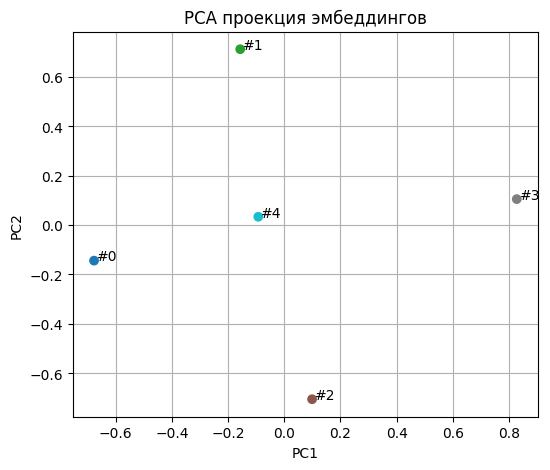

In [31]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6, 5))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=range(5), cmap='tab10')
for i in range(len(emb_2d)):
    plt.text(emb_2d[i, 0]+0.01, emb_2d[i, 1], f'#{i}')
plt.title("PCA проекция эмбеддингов")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


🎯 Цель
Ты теперь:

Видишь, что эмбеддинги — векторы в пространстве, над которыми работают классические методы алгебры.

Понимаешь, как работает cosine similarity, угол, dot, norm.

Умеешь визуализировать даже высокомерные данные в 2D.